In [37]:
from rdkit import Chem
from ergochemics.standardize import standardize_smiles
from ergochemics.draw import draw_molecule
from copy import deepcopy
from hydra import compose, initialize
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from IPython.display import SVG

In [38]:
with initialize(version_base=None, config_path="./conf/filepaths", job_name="filepaths"):
    filepaths = compose(config_name="filepaths")

In [39]:
def neutralize_atoms(mol):
    mol = deepcopy(mol)
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    for at_idx in at_matches_list:
        atom = mol.GetAtomWithIdx(at_idx)
        chg = atom.GetFormalCharge()
        hcount = atom.GetTotalNumHs()
        atom.SetFormalCharge(0)
        atom.SetNumExplicitHs(hcount - chg)
        atom.UpdatePropertyCache()
    return mol

In [40]:
rhea = pd.read_csv(Path(filepaths.raw_data) / "pathway" / "rhea-reaction-smiles.tsv", sep="\t", header=None)
rhea.head()

,0,1
0,10001,CCCCC(N)=O.[H]O[H]>>CCCCC(=O)[O-].[H][N+]([H])...
1,10002,CCCCC(=O)[O-].[H][N+]([H])([H])[H]>>CCCCC(N)=O...
2,10005,S=C=NCC1=CC=CC=C1>>N#CSCC1=CC=CC=C1
3,10006,N#CSCC1=CC=CC=C1>>S=C=NCC1=CC=CC=C1
4,10009,*OO.*N[C@@H](CS)C(*)=O.*N[C@@H](CS)C(*)=O>>*N[...


In [41]:
smiles = set()
for _, row in rhea.iterrows():
    rxn_smiles = row[1]
    lhs, rhs = [side.split(".") for side in rxn_smiles.split(">>")]
    row_smiles = lhs + rhs
    for smi in row_smiles:
        smiles.add(smi)

print(len(smiles))

13036


In [42]:
diffs = []
probs = []
for smi in tqdm(smiles):
    try:
        old_std = standardize_smiles(smi)
        new_std = standardize_smiles(smi, do_neutralize_atoms=False)
        new_std = Chem.MolToSmiles(neutralize_atoms(Chem.MolFromSmiles(new_std)))
        if old_std != new_std:
            diffs.append((smi, old_std, new_std))
    except Exception as e:
        print(f"Error processing {smi}: {e}")
        probs.append(smi)
print(len(diffs))

 30%|██▉       | 3880/13036 [00:14<00:38, 235.81it/s][15:12:12] Can't kekulize mol.  Unkekulized atoms: 4 9
[15:12:12] Can't kekulize mol.  Unkekulized atoms: 4 9
 36%|███▋      | 4749/13036 [00:18<00:36, 226.02it/s][15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[15:12:16] WARNING: not removing hydrogen atom with du

Error processing [H]O[B-](O[H])(O[H])O[H]: Explicit valence for atom # 1 B, 5, is greater than permitted


 99%|█████████▉| 12938/13036 [00:51<00:00, 254.15it/s][15:12:50] WARNING: not removing hydrogen atom without neighbors
[15:12:50] WARNING: not removing hydrogen atom without neighbors
[15:12:50] WARNING: not removing hydrogen atom without neighbors
[15:12:50] WARNING: not removing hydrogen atom without neighbors
[15:12:50] WARNING: not removing hydrogen atom without neighbors
[15:12:50] WARNING: not removing hydrogen atom without neighbors
[15:12:50] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 13036/13036 [00:52<00:00, 250.62it/s]

52


In [43]:
diffs

[('[NH3+][C@H](CCOC1=CC=C(/C(=N/[O-])C(=O)N[C@H]2CN([C@@H](C(=O)[O-])C3=CC=C(O)C=C3)C2=O)C=C1)C(=O)[O-]',
  'NC(CCOc1ccc(C(=N[O-])C(=O)NC2CN(C(C(=O)O)c3ccc(O)cc3)C2=O)cc1)C(=O)O',
  'NC(CCOc1ccc(C(=NO)C(=O)NC2CN(C(C(=O)O)c3ccc(O)cc3)C2=O)cc1)C(=O)O'),
 ('O=N[O-]', 'O=N[O-]', 'O=NO'),
 ('*C1=C(*)/C2=C/C3=C(*)C(*)=C4/C=C5/[C@@H](C)[C@H](CCC(=O)OC/C=C(\\C)CCC[C@H](C)CCC[C@H](C)CCCC(C)C)C6=[N+]5[Mg-2]5(N34)N3C4=C6[C-](C(=O)OC)C(=O)/C4=C(C)/C3=C/C1=[N+]25',
  '*C1=C(*)c2cc3[nH]c4c(c3C)C(=O)[C-](C(=O)OC)c4c3nc(cc4[nH]c(cc1n2)c(*)c4*)C(C)C3CCC(=O)OCC=C(C)CCCC(C)CCCC(C)CCCC(C)C',
  '*C1=C(*)c2cc3[nH]c4c(c3C)C(=O)C(C(=O)OC)c4c3nc(cc4[nH]c(cc1n2)c(*)c4*)C(C)C3CCC(=O)OCC=C(C)CCCC(C)CCCC(C)CCCC(C)C'),
 ('[F-]', '[F-]', 'F'),
 ('O=C(N[C@H]1CN([C@@H](C(=O)[O-])C2=CC=C(O)C=C2)C1=O)/C(=N\\[O-])C1=CC=C(O)C=C1',
  'O=C(NC1CN(C(C(=O)O)c2ccc(O)cc2)C1=O)C(=N[O-])c1ccc(O)cc1',
  'O=C(NC1CN(C(C(=O)O)c2ccc(O)cc2)C1=O)C(=NO)c1ccc(O)cc1'),
 ('OC[C@H]1O[C@@H]([Se-])[C@H](O)[C@@H](O)[C@H]1O',
  'OCC1OC([Se-])C(O)

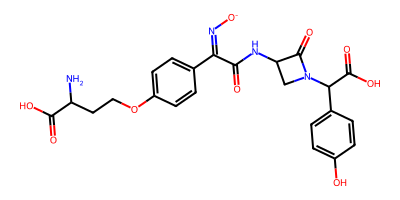

In [44]:
display(
    SVG(
        draw_molecule(
            'NC(CCOc1ccc(C(=N[O-])C(=O)NC2CN(C(C(=O)O)c3ccc(O)cc3)C2=O)cc1)C(=O)O',
            size=(400, 200)
        )
    )
)